In [50]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [51]:
# determine working directories (notebook CWD)
script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
data_dir = parent_dir + '\\1_Data'

In [52]:
# Read data
excel_file = os.path.join(data_dir, 'IEG_ICRR_PPAR_Ratings_2025-03-12.xlsx')
df = pd.read_excel(excel_file)

In [53]:
################################
####### DATA PREPARATION #######
################################

# Filter relevant projects: Human Development (HD) between 2015 and 2025
df2 = df[
    (df['Approval FY'] >= 2015) &
    (df['Approval FY'] <= 2025) &
    (df['Practice Group'] == 'HD')
].copy()

# Drop identifier and text-heavy columns
columns_to_drop = [
    'Data Source', 'Project ID', 'Project Name', 'Evaluation Date',
    'Practice Group', 'TXT'
]
df2.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define mappings for categorical-to-numeric transformations
me_mapping = {'Negligible': 1, 'Modest': 2, 'Substantial': 3, 'High': 4}

rating_mapping = {
    'Highly Unsatisfactory': 1, 'Unsatisfactory': 2, 'Moderately Unsatisfactory': 3,
    'Moderately Satisfactory': 4, 'Satisfactory': 5, 'Highly Satisfactory': 6
}

volume_mapping = {
    'Less than 10 million': 1,
    '>=10 million & <25 million': 2,
    '>=25 million & <50 million': 3,
    '>=50 million & <100 million': 4,
    '>=100 million': 5
}

################################
####### VARIABLE CREATION ######
################################

# Monitoring & Evaluation quality score
df2['ME_score'] = df2['IEG Monitoring and Evaluation Quality Ratings'].map(me_mapping)
df2.drop(columns=['IEG Monitoring and Evaluation Quality Ratings'], inplace=True, errors='ignore')

# Outcome score
df2['outcome_score'] = df2['IEG Outcome Ratings'].map(rating_mapping)
df2.drop(columns=['IEG Outcome Ratings'], inplace=True, errors='ignore')

# Covariates: quality and performance ratings
df2['Quality at Entry (1=bad–6=good)'] = df2['IEG Quality at Entry Ratings'].map(rating_mapping)
df2['Quality of Supervision (1=bad–6=good)'] = df2['IEG Quality of Supervision Ratings'].map(rating_mapping)
df2['Bank Performance (1=bad–6=good)'] = df2['IEG Bank Performance Ratings'].map(rating_mapping)
df2.drop(columns=[
    'IEG Quality at Entry Ratings',
    'IEG Quality of Supervision Ratings',
    'IEG Bank Performance Ratings'
], inplace=True, errors='ignore')

# Project volume
df2['Volume (1=low–5=high)'] = df2['Project Volume'].map(volume_mapping)
df2.drop(columns=['Project Volume'], inplace=True, errors='ignore')

# Project duration
df2['Duration'] = df2['Closing FY'] - df2['Approval FY']

# Convert categorical variables into dummy/indicator variables
def create_dummies(df, categorical_vars, drop_first=True):
    return pd.get_dummies(df, columns=categorical_vars, drop_first=drop_first)

categorical_vars = [
    'Evaluation Type', 'Global Practice', 'Region', 'Country',
    'Country Lending Group', 'Agreement Type', 'Lending Instrument'
]

df2 = create_dummies(df2, categorical_vars)

# Drop missings
df2 = df2.dropna(subset=['ME_score', 'Country FCS Status'])

# Data for sentiment analysis 
df_text = df2.copy()
df2.drop(columns=['PDF', 'Lesson'], inplace=True, errors='ignore')

In [54]:
country_fe      = [col for col in df2.columns if col.startswith('Country_')]
region_fe       = [col for col in df2.columns if col.startswith('Region_')]
global_prac_fe  = [col for col in df2.columns if col.startswith('Global Practice_')]

project_char = ['Approval FY', 'Closing FY', 'Duration', 'Volume (1=low–5=high)', 'Country FCS Status',
                'Quality at Entry (1=bad–6=good)', 'Quality of Supervision (1=bad–6=good)', 'Bank Performance (1=bad–6=good)']

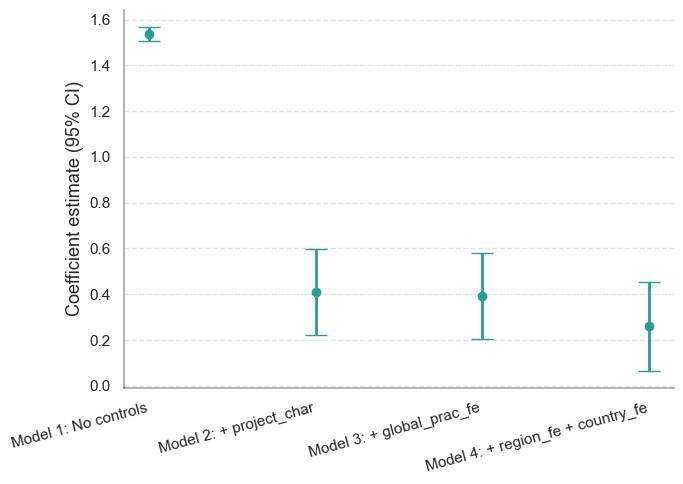

In [42]:
###################################
############ OLS MODEL ############
###################################

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --------- STEP 1: Clean and transform booleans ----------
# Convert boolean columns to integers
df2 = df2.copy()
bool_cols = df2.select_dtypes(include='bool').columns
df2[bool_cols] = df2[bool_cols].astype(int)

# --------- STEP 3: Outcome variable ----------
y = df2['outcome_score'].astype(float)

# --------- STEP 4: Run models ----------
results = []
labels = []

# Model 1
X1 = df2[['ME_score']].copy()
model1 = sm.OLS(y, X1).fit()
results.append(model1)
labels.append("Model 1: No controls")

# Model 2
X2 = df2[['ME_score'] + project_char].copy()
model2 = sm.OLS(y, X2).fit()
results.append(model2)
labels.append("Model 2: + project_char")

# Model 3
X3 = df2[['ME_score'] + project_char + global_prac_fe].copy()
model3 = sm.OLS(y, X3).fit()
results.append(model3)
labels.append("Model 3: + global_prac_fe")

# Model 4
X4 = df2[['ME_score'] + project_char + global_prac_fe + region_fe + country_fe].copy()
model4 = sm.OLS(y, X4).fit()
results.append(model4)
labels.append("Model 4: + region_fe + country_fe")

# --------- STEP 5: Extract coefficients ----------
coef_data = []
for i, model in enumerate(results):
    coef = model.params['ME_score']
    conf_int = model.conf_int().loc['ME_score']
    pval = model.pvalues['ME_score']
    r2 = model.rsquared
    coef_data.append({
        'Model': f'Model {i+1}',
        'Label': labels[i],
        'Coef': coef,
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': pval,
        'R_squared': r2
    })

coef_df = pd.DataFrame(coef_data)


# --------- STEP 6: PLOT ----------
import seaborn as sns
import matplotlib.pyplot as plt

# Configura estilo
sns.set(style="white")

fig, ax = plt.subplots(figsize=(7, 5))

# Color más agradable
color = "#2a9d8f"  # verde azulado

# Error bars
ax.errorbar(
    x=range(len(labels)),
    y=coef_df['Coef'],
    yerr=[coef_df['Coef'] - coef_df['CI_lower'], coef_df['CI_upper'] - coef_df['Coef']],
    fmt='o',
    capsize=8,
    linewidth=2,
    color=color
)

# Línea base en 0
#ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Títulos y etiquetas
ax.set_title("", fontsize=16, weight='bold', pad=20)
ax.set_ylabel("Coefficient estimate (95% CI)", fontsize=13)
ax.set_xlabel("", fontsize=13)

# Etiquetas en eje X
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=15, ha='right', fontsize=11)

# Eliminar grillas
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Estilo de ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.4)
ax.spines['bottom'].set_alpha(0.4)

plt.tight_layout()
plt.show()


c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\wb592581\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


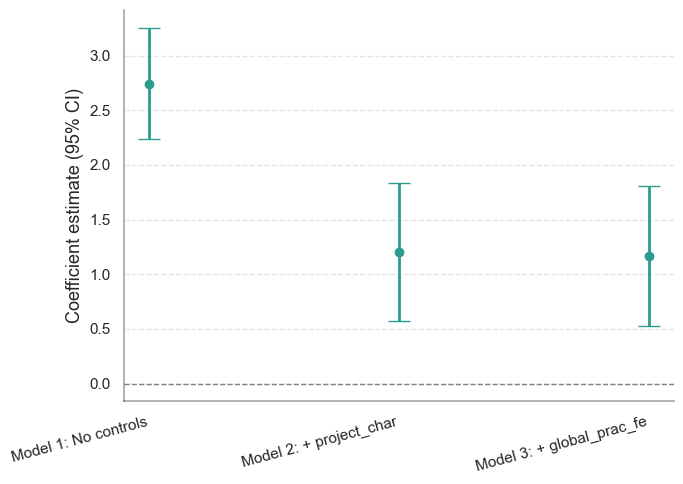

In [43]:
##########################################
########### ORDERED LOGIT MODEL ##########
##########################################

import pandas as pd
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
import matplotlib.pyplot as plt
import seaborn as sns

# --------- STEP 1: Clean and transform booleans ----------
df2 = df2.copy()
bool_cols = df2.select_dtypes(include='bool').columns
df2[bool_cols] = df2[bool_cols].astype(int)

# --------- STEP 2: Ensure outcome is ordinal categorical ----------
y_ord = df2['outcome_score'].astype(int)

# --------- STEP 3: Define function to run Ordered Logit ----------
def run_ordered_logit(y, X):
    model = OrderedModel(y, X, distr='logit')
    result = model.fit(method='bfgs', disp=False)
    return result

# --------- STEP 4: Run models ----------
results = []
labels = []

# Model 1
X1 = df2[['ME_score']].copy()
res1 = run_ordered_logit(y_ord, X1)
results.append(res1)
labels.append("Model 1: No controls")

# Model 2
X2 = df2[['ME_score'] + project_char].copy()
res2 = run_ordered_logit(y_ord, X2)
results.append(res2)
labels.append("Model 2: + project_char")

# Model 3
X3 = df2[['ME_score'] + project_char + global_prac_fe].copy()
res3 = run_ordered_logit(y_ord, X3)
results.append(res3)
labels.append("Model 3: + global_prac_fe")

# Model 4
#X4 = df2[['ME_score'] + project_char + global_prac_fe + region_fe + country_fe].copy()
#X4 = df2[['ME_score'] + project_char + global_prac_fe + country_fe].copy()
#res4 = run_ordered_logit(y_ord, X4)
#results.append(res4)
#labels.append("Model 4: + region_fe + country_fe")

# --------- STEP 5: Extract coefficients for ME_score ----------
coef_data = []
for i, model in enumerate(results):
    coef = model.params['ME_score']
    conf_int = model.conf_int().loc['ME_score']
    pval = model.pvalues['ME_score']
    pseudo_r2 = model.prsquared  # McFadden's pseudo R2
    coef_data.append({
        'Model': f'Model {i+1}',
        'Label': labels[i],
        'Coef': coef,
        'CI_lower': conf_int[0],
        'CI_upper': conf_int[1],
        'P_value': pval,
        'Pseudo_R2': pseudo_r2
    })

coef_df = pd.DataFrame(coef_data)

# --------- STEP 6: PLOT ----------
sns.set(style="white")

fig, ax = plt.subplots(figsize=(7, 5))
color = "#2a9d8f"

ax.errorbar(
    x=range(len(labels)),
    y=coef_df['Coef'],
    yerr=[coef_df['Coef'] - coef_df['CI_lower'], coef_df['CI_upper'] - coef_df['Coef']],
    fmt='o',
    capsize=8,
    linewidth=2,
    color=color
)

# Línea base en 0
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

# Etiquetas
ax.set_ylabel("Coefficient estimate (95% CI)", fontsize=13)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=15, ha='right', fontsize=11)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.4)
ax.spines['bottom'].set_alpha(0.4)

plt.tight_layout()
plt.show()


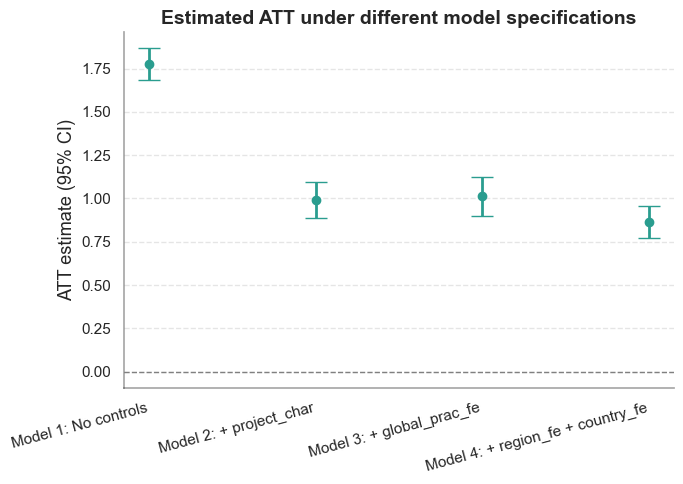

In [44]:
###############################
########### PSM: ATT ##########
###############################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# --------- STEP 1: Clean booleans ----------
df3 = df2.copy()
bool_cols = df3.select_dtypes(include='bool').columns
df3[bool_cols] = df3[bool_cols].astype(int)

# --------- STEP 2: Define variables ----------
y = df3['outcome_score'].astype(float)
df3['ME_high'] = (df3['ME_score'] >= 3).astype(int)
df3.drop(['ME_score'], inplace=True, errors='ignore')

treatment = 'ME_high'

# Define control sets
models = [
    [],  # Model 1: No controls
    project_char,  # Model 2
    project_char + global_prac_fe,  # Model 3
    project_char + global_prac_fe + region_fe + country_fe  # Model 4
]
labels = [
    "Model 1: No controls",
    "Model 2: + project_char",
    "Model 3: + global_prac_fe",
    "Model 4: + region_fe + country_fe"
]

# --------- STEP 3: Function to estimate ATT with CI ----------
def estimate_att_with_ci(df, treat_col, outcome_col, covariates):
    df = df.copy()
    X = df[covariates]
    T = df[treat_col]
    Y = df[outcome_col]

    # Estimate propensity scores
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X, T)
    df['pscore'] = model.predict_proba(X)[:, 1]

    # Split treated and control
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]

    # Nearest neighbor matching
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[['pscore']])
    distances, indices = nn.kneighbors(treated[['pscore']])
    matched_control_outcomes = control.iloc[indices.flatten()][outcome_col].values

    # ATT and CI
    diffs = treated[outcome_col].values - matched_control_outcomes
    att = np.mean(diffs)
    se = np.std(diffs, ddof=1) / np.sqrt(len(diffs))
    ci_low = att - 1.96 * se
    ci_high = att + 1.96 * se

    return att, ci_low, ci_high

# --------- STEP 4: Run models ----------
att_data = []
for i, covars in enumerate(models):
    covars_to_use = covars if covars else ['ME_score']
    att, ci_low, ci_high = estimate_att_with_ci(df3, treatment, 'outcome_score', covars_to_use)
    att_data.append({
        'Model': f'Model {i+1}',
        'Label': labels[i],
        'ATT': att,
        'CI_lower': ci_low,
        'CI_upper': ci_high
    })

att_df = pd.DataFrame(att_data)

# --------- STEP 5: PLOT ----------
sns.set(style="white")
fig, ax = plt.subplots(figsize=(7, 5))
color = "#2a9d8f"

ax.errorbar(
    x=range(len(att_df)),
    y=att_df['ATT'],
    yerr=[att_df['ATT'] - att_df['CI_lower'], att_df['CI_upper'] - att_df['ATT']],
    fmt='o',
    capsize=8,
    linewidth=2,
    color=color
)

# Custom axes
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel("ATT estimate (95% CI)", fontsize=13)
ax.set_xticks(range(len(att_df)))
ax.set_xticklabels(att_df['Label'], rotation=15, ha='right', fontsize=11)
ax.set_title("Estimated ATT under different model specifications", fontsize=14, weight='bold')
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.4)
ax.spines['bottom'].set_alpha(0.4)
plt.tight_layout()
plt.show()

In [ ]:
################################################
########### ML MODEL: STRUCTURED DATA ##########
################################################

import optuna
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from mord import LogisticAT
import numpy as np
from sklearn.model_selection import cross_val_predict

# --------- 1. Preparar datos ----------
y = df2['outcome_score']
X = df2.drop(columns=['outcome_score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

original_columns = X_train.columns

def clean_column_names(df):
    df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    return df

X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

cleaned_columns = [re.sub(r'[^\w]', '_', col) for col in original_columns]
col_name_map = dict(zip(cleaned_columns, original_columns))

# --------- 2. Función objetivo para Optuna ----------
N_TRIALS = 40

def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['random_forest', 'lgbm', 'ordinal_logistic'])

    if model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'random_state': 42
        }
        model = RandomForestRegressor(**params)

    elif model_type == 'lgbm':
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'random_state': 42
        }
        model = LGBMRegressor(**params)

    else:  # ordinal_logistic
        alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )

    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_train, y_train, cv=3)

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    return rmse

# --------- 3. Ejecutar Optuna ----------
study = optuna.create_study(direction='minimize')  # Queremos minimizar RMSE
study.optimize(objective, n_trials=N_TRIALS)

best_params = study.best_params
print("Best model type and parameters:", best_params)

[I 2025-06-22 13:54:56,731] A new study created in memory with name: no-name-ead0dd67-7be4-4944-aa7c-fcdb103e773b


[I 2025-06-22 13:54:57,391] Trial 0 finished with value: 0.6105792475542055 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.00013405913011127918}. Best is trial 0 with value: 0.6105792475542055.
[I 2025-06-22 13:54:57,776] Trial 1 finished with value: 0.6069769786668839 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.03553135332222381}. Best is trial 1 with value: 0.6069769786668839.
[I 2025-06-22 13:54:58,746] Trial 2 finished with value: 0.541448344163618 and parameters: {'model_type': 'random_forest', 'n_estimators': 244, 'max_depth': 18}. Best is trial 2 with value: 0.541448344163618.
[I 2025-06-22 13:54:59,020] Trial 3 finished with value: 0.6069769786668839 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.03509243639967625}. Best is trial 2 with value: 0.541448344163618.
[I 2025-06-22 13:54:59,851] Trial 4 finished with value: 0.5404883962109879 and parameters: {'model_type': 'random_forest', 'n_estimators': 204, 'max_depth': 17}. Best is 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-22 13:55:01,936] Trial 7 finished with value: 0.6033532031234261 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.010797134964077144}. Best is trial 4 with value: 0.5404883962109879.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-22 13:55:02,226] Trial 8 finished with value: 0.5930993457128212 and parameters: {'model_type': 'lgbm', 'num_leaves': 99, 'learning_rate': 0.20867992874208105, 'n_estimators': 272}. Best is trial 4 with value: 0.5404883962109879.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 20
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-22 13:55:02,438] Trial 9 finished with value: 0.5820630711614937 and parameters: {'model_type': 'lgbm', 'num_leaves': 84, 'learning_rate': 0.18353631720482805, 'n_estimators': 203}. Best is trial 4 with value: 0.5404883962109879.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 20
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-22 13:55:03,417] Trial 10 finished with value: 0.6054901587911938 and parameters: {'model_type': 'random_forest', 'n_estimators': 132, 'max_depth': 3}. Best is trial 4 with value: 0.5404883962109879.
[I 2025-06-22 13:55:05,552] Trial 11 finished with value: 0.5406478589498168 and parameters: {'model_type': 'random_forest', 'n_estimators': 286, 'max_depth': 18}. Best is trial 4 with value: 0.5404883962109879.
[I 2025-06-22 13:55:07,046] Trial 12 finished with value: 0.539820897042515 and parameters: {'model_type': 'random_forest', 'n_estimators': 139, 'max_depth': 14}. Best is trial 12 with value: 0.539820897042515.
[I 2025-06-22 13:55:08,276] Trial 13 finished with value: 0.5431772833941115 and parameters: {'model_type': 'random_forest', 'n_estimators': 129, 'max_depth': 12}. Best is trial 12 with value: 0.539820897042515.
[I 2025-06-22 13:55:09,864] Trial 14 finished with value: 0.5403028844645993 and parameters: {'model_type': 'random_forest', 'n_estimators': 173, 'max_dep

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-22 13:55:15,021] Trial 20 finished with value: 0.5416708877636712 and parameters: {'model_type': 'random_forest', 'n_estimators': 183, 'max_depth': 15}. Best is trial 12 with value: 0.539820897042515.
[I 2025-06-22 13:55:16,269] Trial 21 finished with value: 0.5409104203183396 and parameters: {'model_type': 'random_forest', 'n_estimators': 220, 'max_depth': 15}. Best is trial 12 with value: 0.539820897042515.
[I 2025-06-22 13:55:17,091] Trial 22 finished with value: 0.5391759250468212 and parameters: {'model_type': 'random_forest', 'n_estimators': 141, 'max_depth': 16}. Best is trial 22 with value: 0.5391759250468212.
[I 2025-06-22 13:55:17,816] Trial 23 finished with value: 0.5486174630748467 and parameters: {'model_type': 'random_forest', 'n_estimators': 134, 'max_depth': 9}. Best is trial 22 with value: 0.5391759250468212.
[I 2025-06-22 13:55:18,641] Trial 24 finished with value: 0.5397869269513268 and parameters: {'model_type': 'random_forest', 'n_estimators': 144, 'max_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 19
[LightGBM] [Info] Start training from score 4.460526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-06-22 13:55:21,511] Trial 29 finished with value: 0.6033532031234261 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 3.8232698959640063}. Best is trial 22 with value: 0.5391759250468212.
[I 2025-06-22 13:55:21,669] Trial 30 finished with value: 0.6069769786668839 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 7.182114092677859}. Best is trial 22 with value: 0.5391759250468212.
[I 2025-06-22 13:55:22,650] Trial 31 finished with value: 0.5397869269513268 and parameters: {'model_type': 'random_forest', 'n_estimators': 144, 'max_depth': 14}. Best is trial 22 with value: 0.5391759250468212.
[I 2025-06-22 13:55:23,518] Trial 32 finished with value: 0.5400500864137594 and parameters: {'model_type': 'random_forest', 'n_estimators': 151, 'max_depth': 16}. Best is trial 22 with value: 0.5391759250468212.
[I 2025-06-22 13:55:24,706] Trial 33 finished with value: 0.5407309154827276 and parameters: {'model_type': 'random_forest', 'n_estimators': 177, 'max_depth': 17

Best model type and parameters: {'model_type': 'random_forest', 'n_estimators': 141, 'max_depth': 16}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 21
[LightGBM] [Info] Start training from score 4.473684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

C:\Users\wb592581\AppData\Local\Temp\ipykernel_33348\1620273216.py:71: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=train_df, x='Metric', y='Score', hue='Model', ax=axes[0], palette=palette)
C:\Users\wb592581\AppData\Local\Temp\ipykernel_33348\1620273216.py:78: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=axes[1], palette=palette)


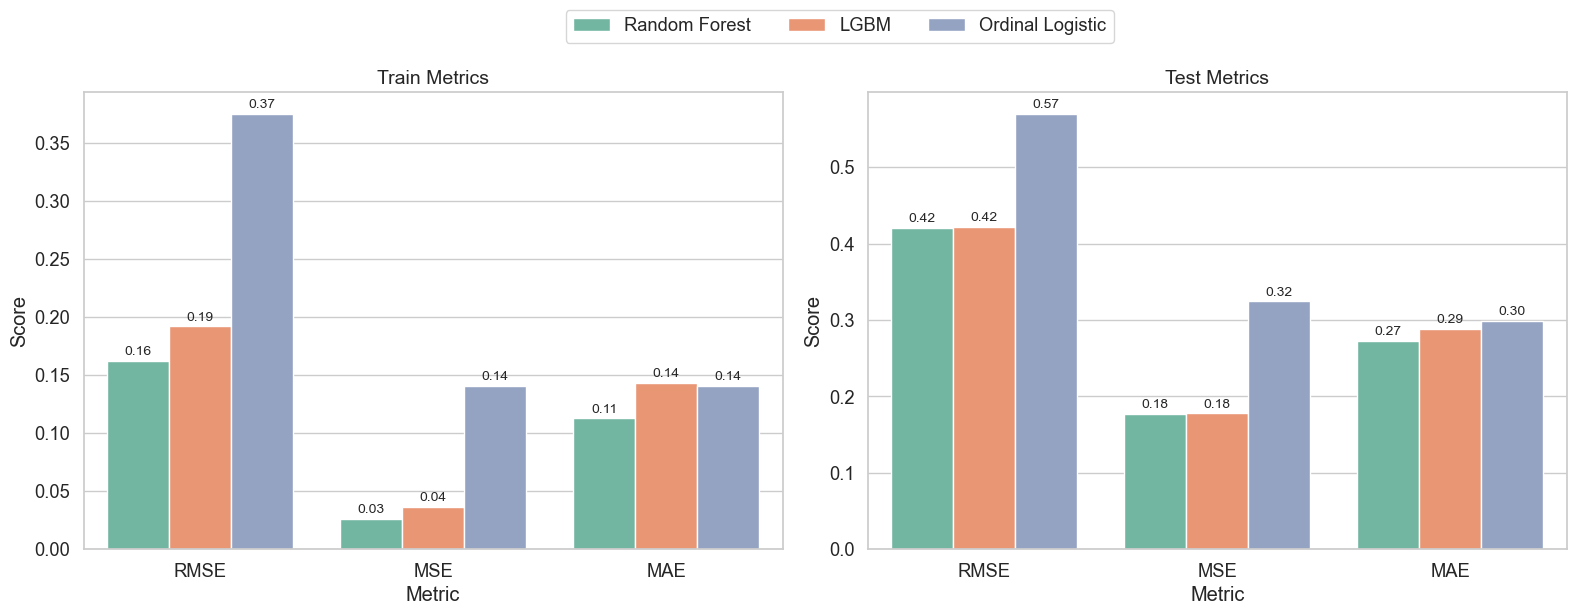

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from mord import LogisticAT
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

results_train = []
results_test = []

for model_type in ['random_forest', 'lgbm', 'ordinal_logistic']:
    # Extraer el mejor trial por tipo de modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    # Para RMSE, buscamos el de menor valor
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar modelo
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        label = 'Random Forest'
    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        label = 'LGBM'
    else:  # ordinal_logistic
        alpha = best_params['alpha']
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )
        label = 'Ordinal Logistic'

    # Entrenar modelo
    model.fit(X_train, y_train)

    # Predicciones TRAIN
    y_train_pred = model.predict(X_train)
    results_train.append({
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred)
    })

    # Predicciones TEST
    y_test_pred = model.predict(X_test)
    results_test.append({
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred)
    })

# Reformatear resultados
train_df = pd.DataFrame(results_train).melt(id_vars='Model', var_name='Metric', value_name='Score')
test_df = pd.DataFrame(results_test).melt(id_vars='Model', var_name='Metric', value_name='Score')

# --------- GRAFICAR ---------
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# TRAIN subplot
sns.barplot(data=train_df, x='Metric', y='Score', hue='Model', ax=axes[0], palette=palette)
axes[0].set_title("Train Metrics", fontsize=14)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', fontsize=10, label_type='edge', padding=2)
axes[0].legend_.remove()

# TEST subplot
sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=axes[1], palette=palette)
axes[1].set_title("Test Metrics", fontsize=14)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', fontsize=10, label_type='edge', padding=2)
axes[1].legend_.remove()

# Ajustes finales
plt.suptitle("", fontsize=16, y=1.05)
plt.tight_layout()
plt.legend(
    title='',
    bbox_to_anchor=(-0.04, 1.2),  
    loc='upper center',
    ncol=3)
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 21
[LightGBM] [Info] Start training from score 4.473684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

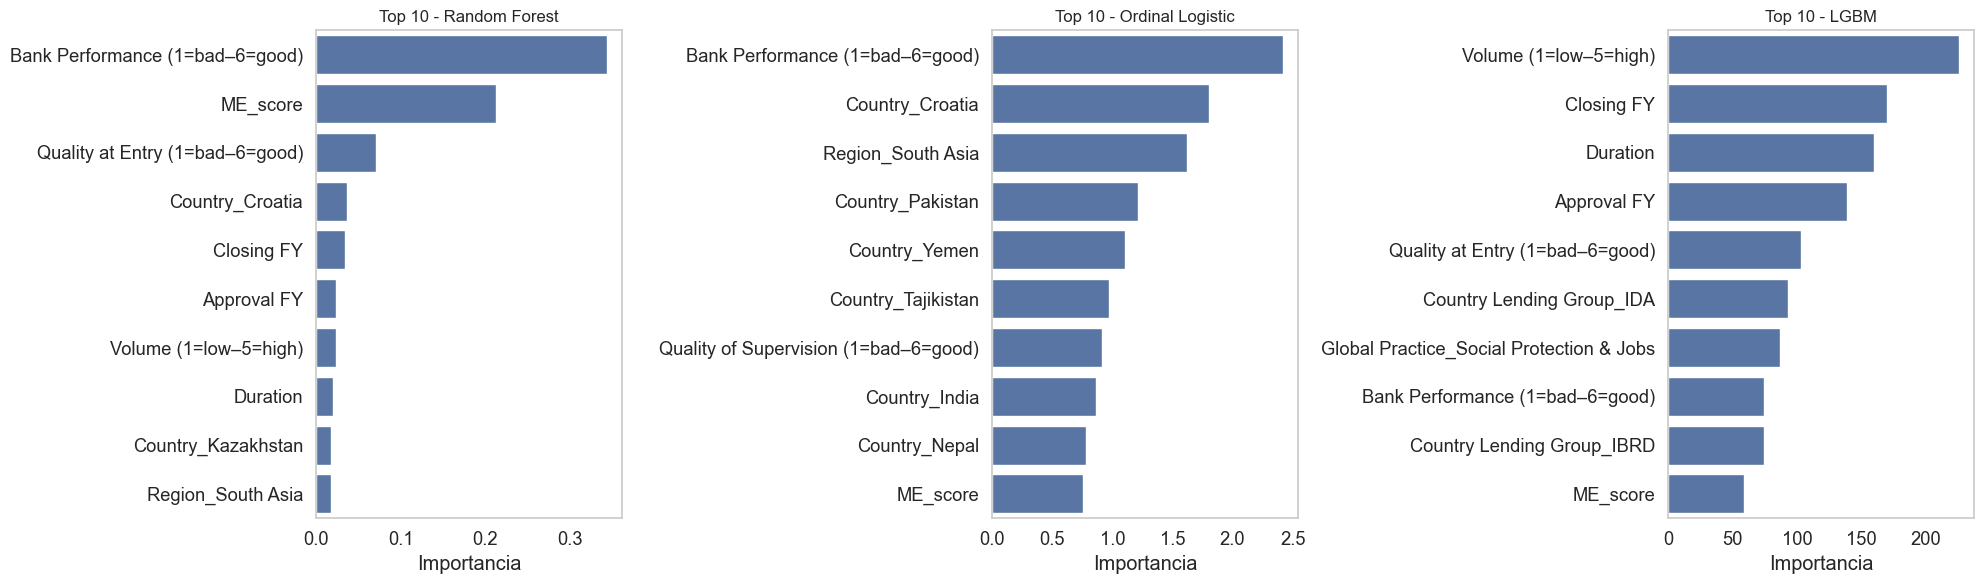

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.set(style="whitegrid")

for i, (model_type, label) in enumerate([
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]):
    # Buscar el mejor trial para este modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)  # usamos min porque optimizamos RMSE
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar y entrenar el modelo
    if model_type == 'random_forest':
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    elif model_type == 'lgbm':
        from lightgbm import LGBMRegressor
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    else:  # ordinal_logistic
        from mord import LogisticAT
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import StandardScaler
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)
        # Extraemos coeficientes del modelo interno (LogisticAT)
        coefs = model.named_steps['logisticat'].coef_
        importances = np.abs(coefs)

    # Crear DataFrame de importancia
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(10)

    importance_df['feature'] = importance_df['feature'].map(col_name_map)

    # Graficar
    sns.barplot(data=importance_df, x='importance', y='feature', ax=axs[i])
    axs[i].set_title(f"Top 10 - {label}")
    axs[i].set_xlabel("Importancia")
    axs[i].set_ylabel("")
    axs[i].grid(False)

plt.tight_layout()
plt.show()


PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE para Random Forest - ME_score ===


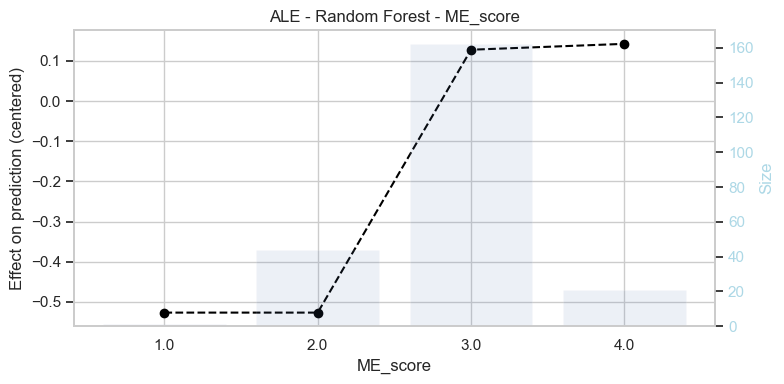

PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE para Ordinal Logistic - ME_score ===


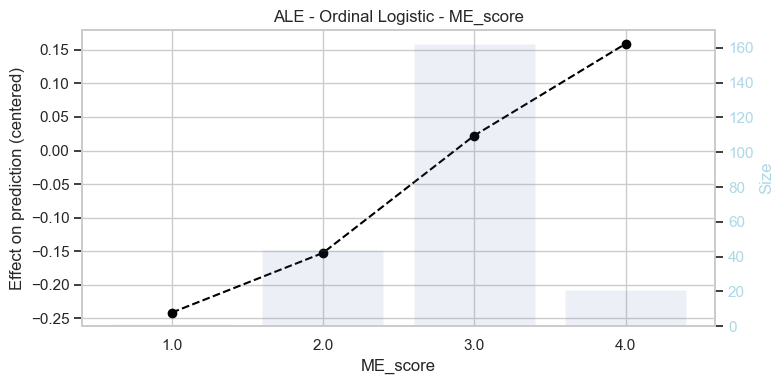

PyALE._ALE_generic:INFO: Discrete feature detected.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 21
[LightGBM] [Info] Start training from score 4.473684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

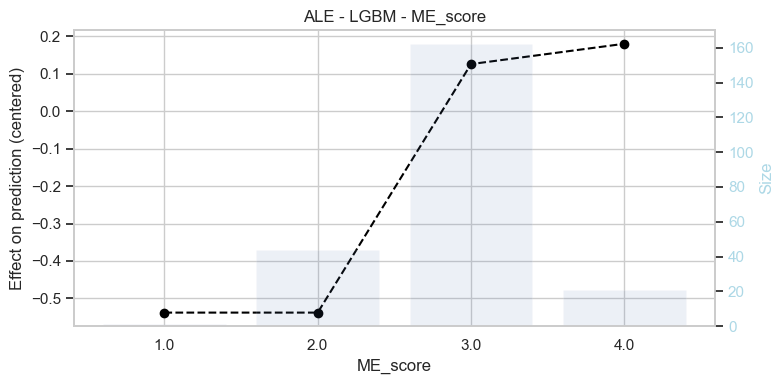

In [48]:
from PyALE import ale
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from mord import LogisticAT
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")

for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Buscar mejor modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar y entrenar el modelo
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Mostrar ALE
    print(f"\n=== ALE para {label} - ME_score ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["ME_score"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - ME_score")
    plt.tight_layout()
    plt.grid(False)
    plt.show()


In [55]:
###############################################
########### ML MODEL: ADD SENTIMENTS ##########
###############################################

# Extract text from PDFS
import requests
import pdfplumber  # pip install pdfplumber
from io import BytesIO
from tqdm import tqdm

# Para ver el progreso
tqdm.pandas()

def extract_text_from_pdf(url):
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        with pdfplumber.open(BytesIO(response.content)) as pdf:
            text = ''.join(page.extract_text() or '' for page in pdf.pages)
        return text.strip()
    except Exception as e:
        return f"[ERROR] {e}"

# Aplica la función a cada fila
df_text['Full Text'] = df_text['PDF'].progress_apply(extract_text_from_pdf)

100%|██████████| 305/305 [17:04<00:00,  3.36s/it]


In [56]:
import re

def extract_section(text, start_pattern, end_pattern, label):
    # Compilar los patrones con tolerancia flexible
    start_regex = re.compile(rf"{start_pattern}", re.IGNORECASE)
    end_regex = re.compile(rf"{end_pattern}", re.IGNORECASE)

    # Buscar líneas
    lines = text.splitlines()
    start_idx = end_idx = None

    for i, line in enumerate(lines):
        if start_idx is None and start_regex.search(line.strip()):
            start_idx = i
        elif start_idx is not None and end_regex.search(line.strip()):
            end_idx = i
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        return "\n".join(lines[start_idx:end_idx+1])
    else:
        return ""  # Si no se encuentra una sección válida

# Aplicar al DataFrame
def extract_sections(row):
    text = row['Full Text']
    me_section = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design.*Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E Section"
    )
    me_design = extract_section(
        text,
        start_pattern=r"\bM&E\s+Design\b", 
        end_pattern=r"\bM&E\s+Implementation\b", 
        label="M&E: Design"
    )
    me_implementation = extract_section(
        text,
        start_pattern=r"\bM&E\s+Implementation\b", 
        end_pattern=r"\bM&E\s+Utilization\b", 
        label="M&E: Implementation"
    )
    me_utilization = extract_section(
        text,
        start_pattern=r"\bM&E\s+Utilization\b", 
        end_pattern=r"\bM&E\s+Quality\s+Rating\b", 
        label="M&E: Utilization"
    )
    outcome_section = extract_section(
        text,
        start_pattern = r'[567][\.\)]?\s*Outcome\b.*',
        end_pattern=r'(IEG\s+)?Outcome\s+Rating\b.*',
        label="Outcome_section"
    )
    return pd.Series({'M&E Section': me_section, 'M&E: Design': me_design, 
                      'M&E: Implementation': me_implementation, 'M&E: Utilization': me_utilization, 
                      'Outcome_section': outcome_section})

# Aplica al DataFrame df2
df_text[['M&E Section', 'M&E: Design', 'M&E: Implementation', 'M&E: Utilization', 'Outcome_section']] = df_text.apply(extract_sections, axis=1)

In [70]:
# Sentiment Analysis
from textblob import TextBlob

df_text2 = df_text.copy()

def simple_sentiment(text):
    if pd.isnull(text):
        return np.nan  
    blob = TextBlob(str(text)) 
    return blob.sentiment.polarity 

# Aplicar la función al dataframe
df_text2['M&E Section (sentiment)'] = df_text2['M&E Section'].apply(simple_sentiment)
df_text2['M&E: Design (sentiment)'] = df_text2['M&E: Design'].apply(simple_sentiment)
df_text2['M&E: Implementation (sentiment)'] = df_text2['M&E: Implementation'].apply(simple_sentiment)
df_text2['M&E: Utilization (sentiment)'] = df_text2['M&E: Utilization'].apply(simple_sentiment)
df_text2['Lesson (sentiment)'] = df_text2['Lesson'].apply(simple_sentiment)
df_text2['Full Text (sentiment)'] = df_text2['Full Text'].apply(simple_sentiment)

df_text2.drop(columns=['PDF', 'Lesson', 'Full Text', 'M&E Section', 'M&E: Design', 'M&E: Implementation', 
                       'M&E: Utilization', 'Outcome_section'], inplace=True, errors='ignore')

In [ ]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def classify_sentiment_vader(text):
    if not isinstance(text, str) or text.strip() == "":
        return 'Neutral'  # Opcional: puedes poner NaN
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
df2['sentiment_M_E_section'] = df2['M_E_section'].apply(classify_sentiment_vader)
df2['sentiment_M_E_design'] = df2['M_E_design'].apply(classify_sentiment_vader)
df2['sentiment_ME_implementation'] = df2['ME_implementation'].apply(classify_sentiment_vader)
df2['sentiment_ME_utilization'] = df2['ME_utilization'].apply(classify_sentiment_vader)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista de columnas de sentimiento y títulos legibles
sentiment_cols = ['sentiment_M_E_design', 'sentiment_ME_implementation', 'sentiment_ME_utilization']
titles = ['Design', 'Implementation', 'Utilization']

# Crear figura con 3 columnas (una por sección)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Iterar para cada sección
for i, col in enumerate(sentiment_cols):
    # Crear tabla cruzada: filas = ratings, columnas = sentimiento
    ctab = pd.crosstab(df2['IEG Monitoring and Evaluation Quality Ratings'], df2[col], normalize='index')
    
    # Asegurar orden correcto de columnas
    ctab = ctab[['Negative', 'Neutral', 'Positive']]  # orden de sentimientos

    # Asegurar orden deseado de ratings
    ctab = ctab.reindex(['High', 'Substantial', 'Modest', 'Negligible'])

    # Graficar
    ctab.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'Sentiment in {titles[i]} Section')
    axes[i].set_xlabel('M&E Quality Rating')
    if i == 0:
        axes[i].set_ylabel('Proportion of Sentiment')
    axes[i].legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Título general
fig.suptitle('Sentiment Composition by M&E Quality Rating in Each Section', fontsize=16)
plt.tight_layout()
plt.show()

In [72]:
df_text3 = df_text2.copy()
df_text3.drop(['Full Text (sentiment)'], inplace=True, errors='ignore')

In [75]:
missing_summary = df_text3.isnull().sum()
missing_summary

Approval FY                        0
Closing FY                         0
Country FCS Status                 0
ME_score                           0
outcome_score                      0
                                  ..
M&E: Design (sentiment)            0
M&E: Implementation (sentiment)    0
M&E: Utilization (sentiment)       0
Lesson (sentiment)                 4
Full Text (sentiment)              0
Length: 114, dtype: int64

In [76]:
df_text3 = df_text3.dropna(subset=['Lesson (sentiment)'])

In [77]:

# --------- 1. Preparar datos ----------
y = df_text3['outcome_score']
X = df_text3.drop(columns=['outcome_score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

original_columns = X_train.columns

def clean_column_names(df):
    df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
    return df

X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

cleaned_columns = [re.sub(r'[^\w]', '_', col) for col in original_columns]
col_name_map = dict(zip(cleaned_columns, original_columns))

# --------- 2. Función objetivo para Optuna ----------
N_TRIALS = 40

def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['random_forest', 'lgbm', 'ordinal_logistic'])

    if model_type == 'random_forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'random_state': 42
        }
        model = RandomForestRegressor(**params)

    elif model_type == 'lgbm':
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'random_state': 42
        }
        model = LGBMRegressor(**params)

    else:  # ordinal_logistic
        alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )

    # Cross-validated predictions
    y_pred = cross_val_predict(model, X_train, y_train, cv=3)

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    return rmse

# --------- 3. Ejecutar Optuna ----------
study = optuna.create_study(direction='minimize')  # Queremos minimizar RMSE
study.optimize(objective, n_trials=N_TRIALS)

best_params = study.best_params
print("Best model type and parameters:", best_params)


[I 2025-06-22 14:54:04,840] A new study created in memory with name: no-name-24f3ac84-5070-44b7-90b4-8cf7170fc0b8


[I 2025-06-22 14:54:05,541] Trial 0 finished with value: 0.5911545775581047 and parameters: {'model_type': 'random_forest', 'n_estimators': 144, 'max_depth': 17}. Best is trial 0 with value: 0.5911545775581047.
[I 2025-06-22 14:54:06,539] Trial 1 finished with value: 0.6569275850463042 and parameters: {'model_type': 'random_forest', 'n_estimators': 283, 'max_depth': 3}. Best is trial 0 with value: 0.5911545775581047.
[I 2025-06-22 14:54:06,628] Trial 2 finished with value: 0.6348504156453288 and parameters: {'model_type': 'lgbm', 'num_leaves': 86, 'learning_rate': 0.13914002765673622, 'n_estimators': 186}. Best is trial 0 with value: 0.5911545775581047.
[I 2025-06-22 14:54:06,736] Trial 3 finished with value: 0.6535550067155089 and parameters: {'model_type': 'lgbm', 'num_leaves': 100, 'learning_rate': 0.2058401907418403, 'n_estimators': 276}. Best is trial 0 with value: 0.5911545775581047.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-06-22 14:54:07,381] Trial 4 finished with value: 0.8379870059984357 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.0002475094073809698}. Best is trial 0 with value: 0.5911545775581047.
[I 2025-06-22 14:54:07,467] Trial 5 finished with value: 0.6341786130688182 and parameters: {'model_type': 'lgbm', 'num_leaves': 69, 'learning_rate': 0.22150983804120605, 'n_estimators': 180}. Best is trial 0 with value: 0.5911545775581047.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-06-22 14:54:08,131] Trial 6 finished with value: 0.8353309390761112 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.0008342030162595083}. Best is trial 0 with value: 0.5911545775581047.
[I 2025-06-22 14:54:08,825] Trial 7 finished with value: 0.8192137151629671 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.0033081396814355797}. Best is trial 0 with value: 0.5911545775581047.
[I 2025-06-22 14:54:11,486] Trial 8 finished with value: 0.5863211400525843 and parameters: {'model_type': 'random_forest', 'n_estimators': 275, 'max_depth': 17}. Best is trial 8 with value: 0.5863211400525843.
[I 2025-06-22 14:54:12,573] Trial 9 finished with value: 0.8353309390761112 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.001872638980363419}. Best is trial 8 with value: 0.5863211400525843.
[I 2025-06-22 14:54:14,755] Trial 10 finished with value: 0.5862677491972464 and parameters: {'model_type': 'random_forest', 'n_estimators': 235, 'max_depth': 19}. Be

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-22 14:54:28,075] Trial 20 finished with value: 0.5951396261411634 and parameters: {'model_type': 'random_forest', 'n_estimators': 155, 'max_depth': 8}. Best is trial 18 with value: 0.5860282976258143.
[I 2025-06-22 14:54:29,825] Trial 21 finished with value: 0.5861601553905352 and parameters: {'model_type': 'random_forest', 'n_estimators': 253, 'max_depth': 14}. Best is trial 18 with value: 0.5860282976258143.
[I 2025-06-22 14:54:31,586] Trial 22 finished with value: 0.5861949769220071 and parameters: {'model_type': 'random_forest', 'n_estimators': 257, 'max_depth': 14}. Best is trial 18 with value: 0.5860282976258143.
[I 2025-06-22 14:54:34,176] Trial 23 finished with value: 0.5856862795913328 and parameters: {'model_type': 'random_forest', 'n_estimators': 293, 'max_depth': 16}. Best is trial 23 with value: 0.5856862795913328.
[I 2025-06-22 14:54:36,526] Trial 24 finished with value: 0.5857511994541285 and parameters: {'model_type': 'random_forest', 'n_estimators': 288, 'ma

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-22 14:54:43,067] Trial 29 finished with value: 0.6463573143221772 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 6.571478496004204}. Best is trial 23 with value: 0.5856862795913328.
[I 2025-06-22 14:54:45,306] Trial 30 finished with value: 0.5864311894902422 and parameters: {'model_type': 'random_forest', 'n_estimators': 268, 'max_depth': 16}. Best is trial 23 with value: 0.5856862795913328.
[I 2025-06-22 14:54:47,136] Trial 31 finished with value: 0.5859747427516565 and parameters: {'model_type': 'random_forest', 'n_estimators': 287, 'max_depth': 15}. Best is trial 23 with value: 0.5856862795913328.
[I 2025-06-22 14:54:49,160] Trial 32 finished with value: 0.5857564911681947 and parameters: {'model_type': 'random_forest', 'n_estimators': 289, 'max_depth': 16}. Best is trial 23 with value: 0.5856862795913328.
[I 2025-06-22 14:54:51,076] Trial 33 finished with value: 0.585860512385333 and parameters: {'model_type': 'random_forest', 'n_estimators': 296, 'max_depth

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-06-22 14:54:57,546] Trial 37 finished with value: 0.5862638154684621 and parameters: {'model_type': 'random_forest', 'n_estimators': 286, 'max_depth': 19}. Best is trial 23 with value: 0.5856862795913328.
[I 2025-06-22 14:54:57,750] Trial 38 finished with value: 0.7483314773547883 and parameters: {'model_type': 'ordinal_logistic', 'alpha': 0.6280368156911295}. Best is trial 23 with value: 0.5856862795913328.
[I 2025-06-22 14:54:57,967] Trial 39 finished with value: 0.6471508400250849 and parameters: {'model_type': 'lgbm', 'num_leaves': 55, 'learning_rate': 0.10147617359893976, 'n_estimators': 261}. Best is trial 23 with value: 0.5856862795913328.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 25
[LightGBM] [Info] Start training from score 4.506667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\wb592581\AppData\Local\Temp\ipykernel_33348\2523096533.py:64: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=train_df, x='Metric', y='Score', hue='Model', ax=axes[0], palette=palette)
C:\Users\wb592581\AppData\Local\Temp\ipykernel_33348\2523096533.py:71: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=axes[1], palette=palette)


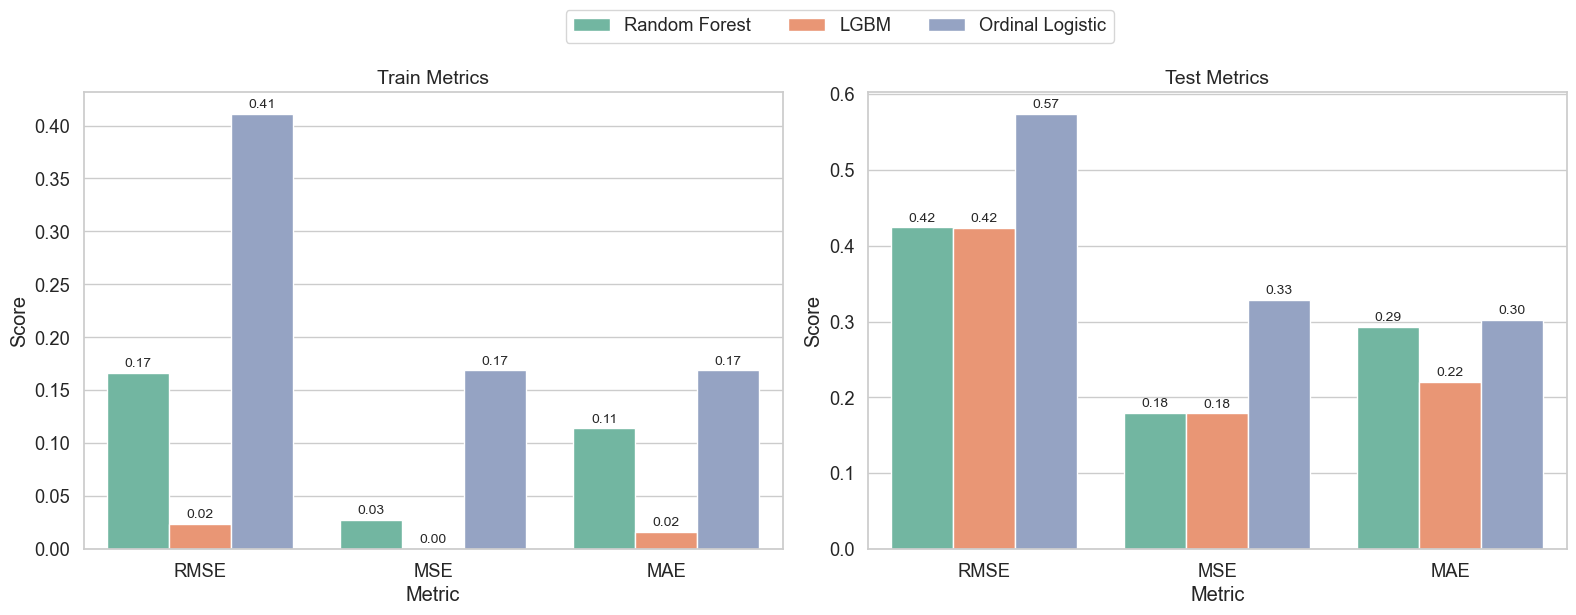

In [78]:
results_train = []
results_test = []

for model_type in ['random_forest', 'lgbm', 'ordinal_logistic']:
    # Extraer el mejor trial por tipo de modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    # Para RMSE, buscamos el de menor valor
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar modelo
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        label = 'Random Forest'
    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        label = 'LGBM'
    else:  # ordinal_logistic
        alpha = best_params['alpha']
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=alpha)
        )
        label = 'Ordinal Logistic'

    # Entrenar modelo
    model.fit(X_train, y_train)

    # Predicciones TRAIN
    y_train_pred = model.predict(X_train)
    results_train.append({
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred)
    })

    # Predicciones TEST
    y_test_pred = model.predict(X_test)
    results_test.append({
        'Model': label,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred)
    })

# Reformatear resultados
train_df = pd.DataFrame(results_train).melt(id_vars='Model', var_name='Metric', value_name='Score')
test_df = pd.DataFrame(results_test).melt(id_vars='Model', var_name='Metric', value_name='Score')

# --------- GRAFICAR ---------
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# TRAIN subplot
sns.barplot(data=train_df, x='Metric', y='Score', hue='Model', ax=axes[0], palette=palette)
axes[0].set_title("Train Metrics", fontsize=14)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', fontsize=10, label_type='edge', padding=2)
axes[0].legend_.remove()

# TEST subplot
sns.barplot(data=test_df, x='Metric', y='Score', hue='Model', ax=axes[1], palette=palette)
axes[1].set_title("Test Metrics", fontsize=14)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', fontsize=10, label_type='edge', padding=2)
axes[1].legend_.remove()

# Ajustes finales
plt.suptitle("", fontsize=16, y=1.05)
plt.tight_layout()
plt.legend(
    title='',
    bbox_to_anchor=(-0.04, 1.2),  
    loc='upper center',
    ncol=3)
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

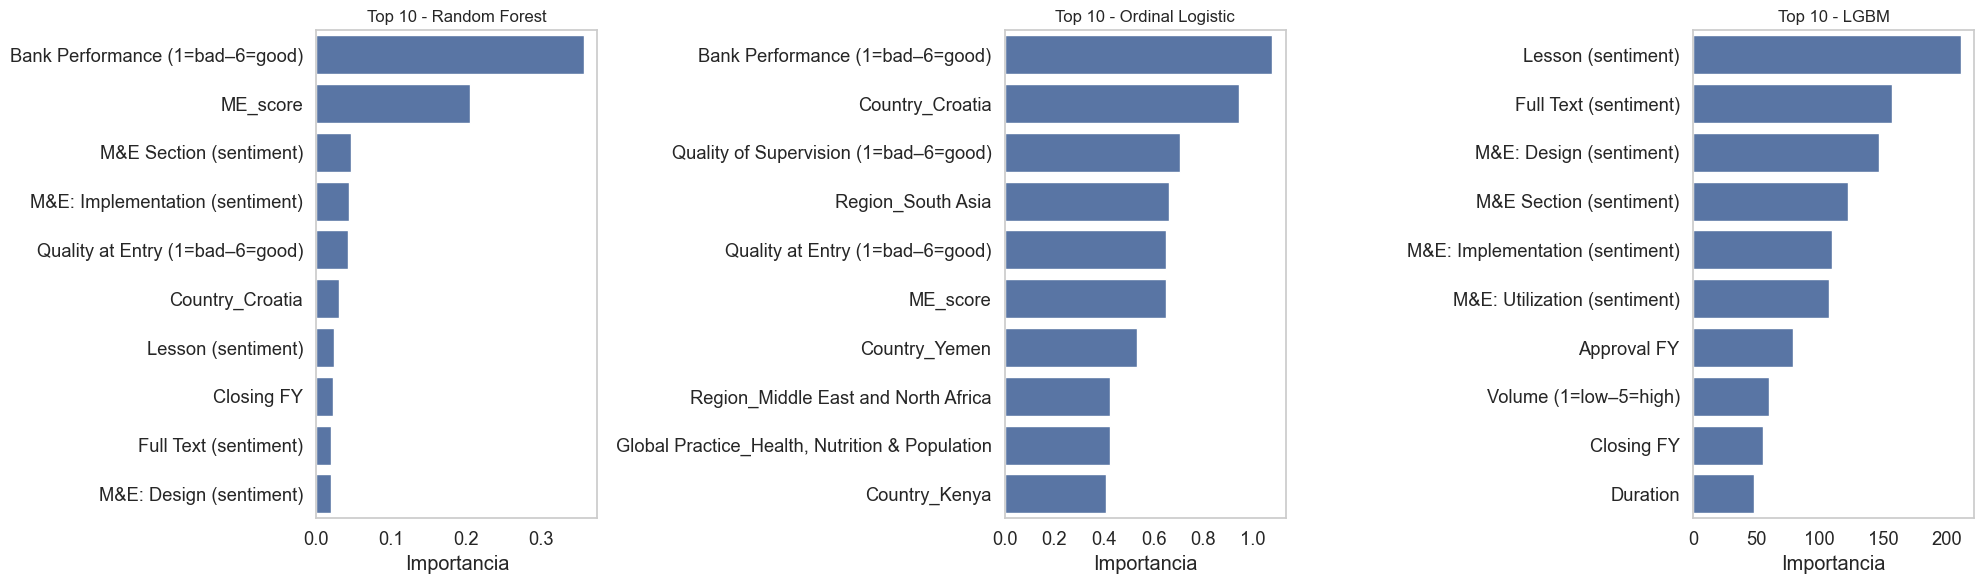

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.set(style="whitegrid")

for i, (model_type, label) in enumerate([
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]):
    # Buscar el mejor trial para este modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)  # usamos min porque optimizamos RMSE
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar y entrenar el modelo
    if model_type == 'random_forest':
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    elif model_type == 'lgbm':
        from lightgbm import LGBMRegressor
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)
        importances = model.feature_importances_

    else:  # ordinal_logistic
        from mord import LogisticAT
        from sklearn.pipeline import make_pipeline
        from sklearn.preprocessing import StandardScaler
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)
        # Extraemos coeficientes del modelo interno (LogisticAT)
        coefs = model.named_steps['logisticat'].coef_
        importances = np.abs(coefs)

    # Crear DataFrame de importancia
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(10)

    importance_df['feature'] = importance_df['feature'].map(col_name_map)

    # Graficar
    sns.barplot(data=importance_df, x='importance', y='feature', ax=axs[i])
    axs[i].set_title(f"Top 10 - {label}")
    axs[i].set_xlabel("Importancia")
    axs[i].set_ylabel("")
    axs[i].grid(False)

plt.tight_layout()
plt.show()


PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE para Random Forest - ME_score ===


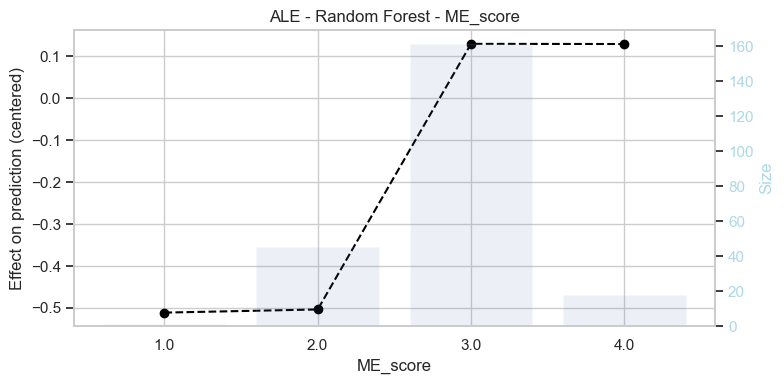

PyALE._ALE_generic:INFO: Discrete feature detected.



=== ALE para Ordinal Logistic - ME_score ===


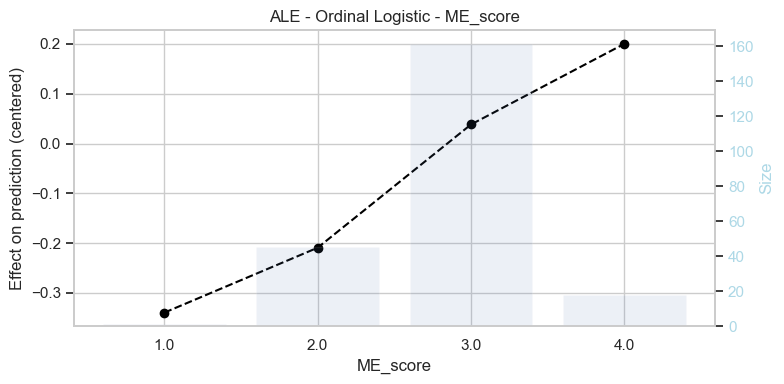

PyALE._ALE_generic:INFO: Discrete feature detected.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

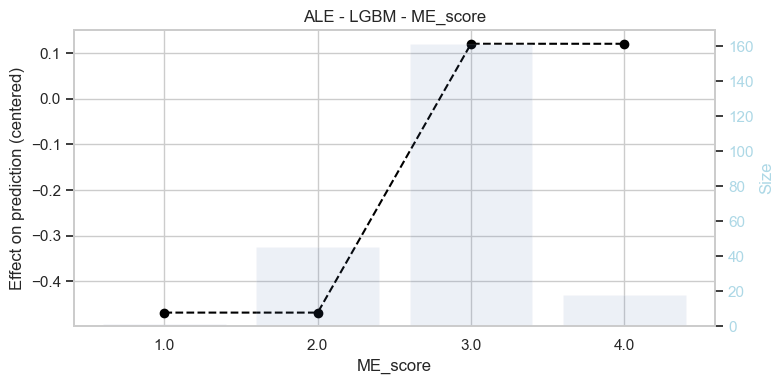

In [80]:
sns.set(style="whitegrid")

for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Buscar mejor modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar y entrenar el modelo
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Mostrar ALE
    print(f"\n=== ALE para {label} - ME_score ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["ME_score"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - ME_score")
    plt.tight_layout()
    plt.grid(False)
    plt.show()


PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE para Random Forest - M_E__Utilization__sentiment_ ===


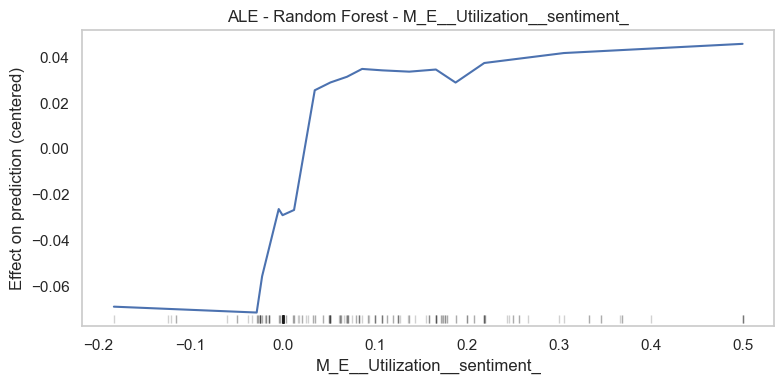

PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE para Ordinal Logistic - M_E__Utilization__sentiment_ ===


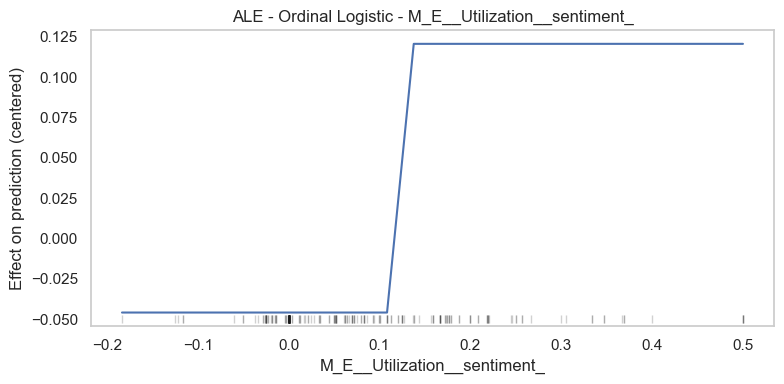

PyALE._ALE_generic:INFO: Continuous feature detected.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

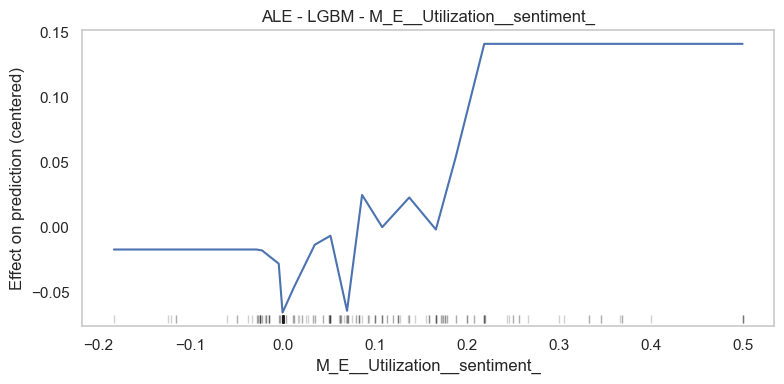

In [85]:
sns.set(style="whitegrid")

for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Buscar mejor modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar y entrenar el modelo
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Mostrar ALE
    print(f"\n=== ALE para {label} - M_E__Utilization__sentiment_ ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["M_E__Utilization__sentiment_"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - M_E__Utilization__sentiment_")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE para Random Forest - M_E__Implementation__sentiment_ ===


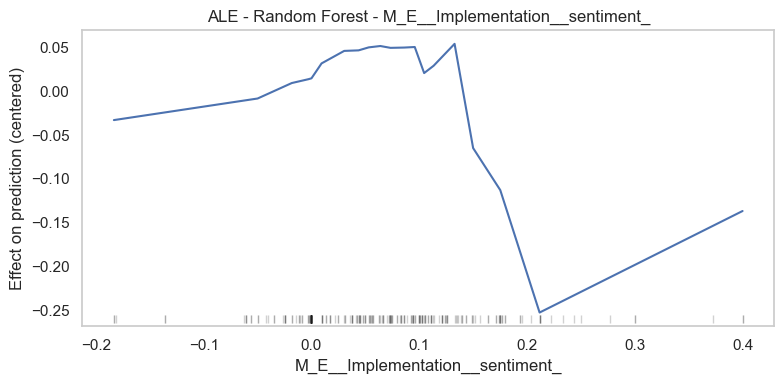

PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE para Ordinal Logistic - M_E__Implementation__sentiment_ ===


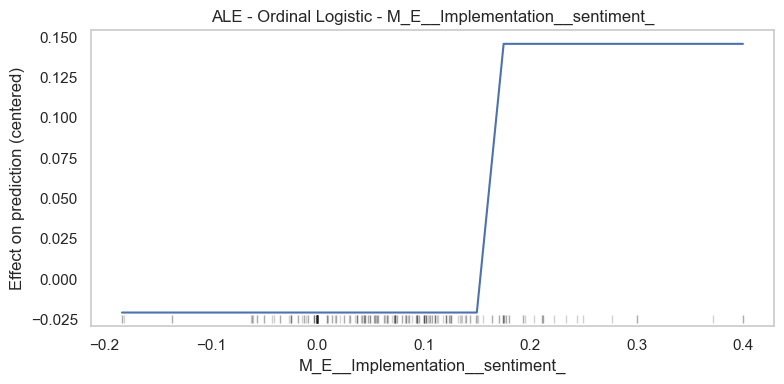

PyALE._ALE_generic:INFO: Continuous feature detected.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

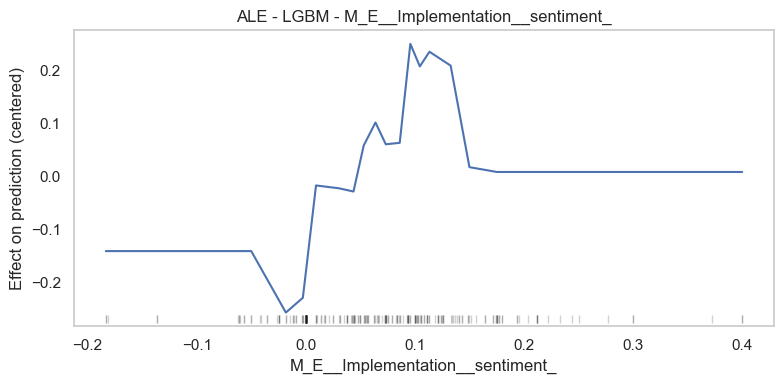

In [84]:
sns.set(style="whitegrid")

for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Buscar mejor modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar y entrenar el modelo
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Mostrar ALE
    print(f"\n=== ALE para {label} - M_E__Implementation__sentiment_ ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["M_E__Implementation__sentiment_"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - M_E__Implementation__sentiment_")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE para Random Forest - M_E__Design__sentiment_ ===


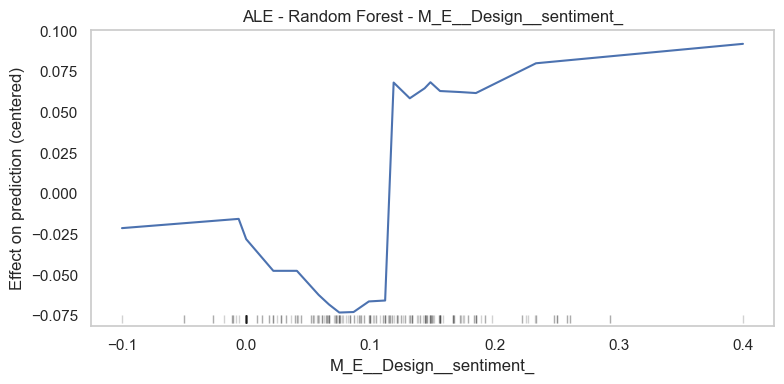

PyALE._ALE_generic:INFO: Continuous feature detected.



=== ALE para Ordinal Logistic - M_E__Design__sentiment_ ===


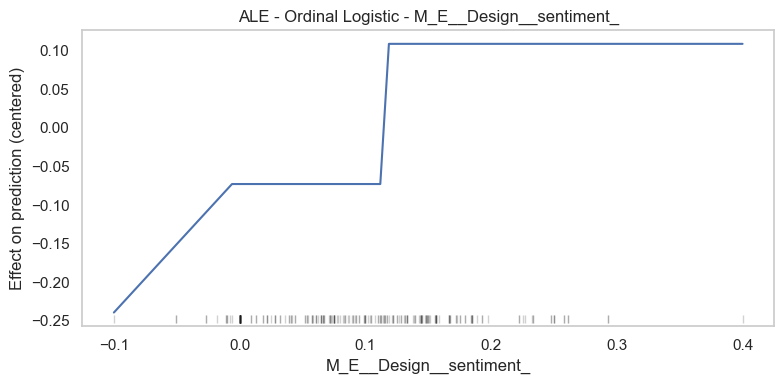

PyALE._ALE_generic:INFO: Continuous feature detected.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 225, number of used features: 26
[LightGBM] [Info] Start training from score 4.466667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

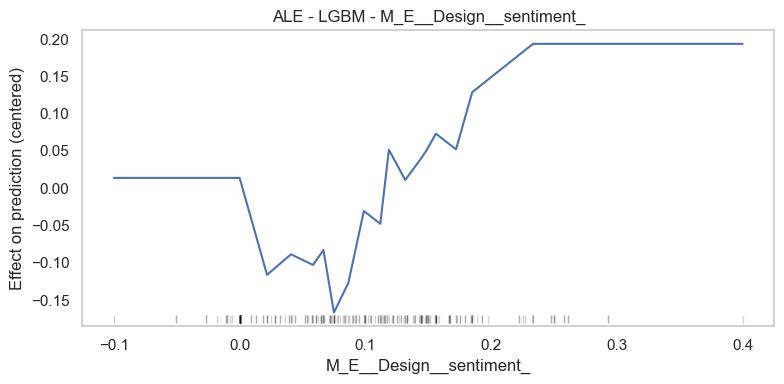

In [83]:
sns.set(style="whitegrid")

for model_type, label in [
    ('random_forest', 'Random Forest'),
    ('ordinal_logistic', 'Ordinal Logistic'),
    ('lgbm', 'LGBM')
]:
    # Buscar mejor modelo
    trials = [t for t in study.trials if t.params.get('model_type') == model_type and t.value is not None]
    if not trials:
        continue
    best_trial = min(trials, key=lambda t: t.value)
    best_params = best_trial.params.copy()
    best_params.pop('model_type')

    # Instanciar y entrenar el modelo
    if model_type == 'random_forest':
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    elif model_type == 'lgbm':
        model = LGBMRegressor(**best_params, random_state=42)
        model.fit(X_train, y_train)

    else:  # ordinal_logistic
        model = make_pipeline(
            StandardScaler(),
            LogisticAT(alpha=best_params['alpha'])
        )
        model.fit(X_train, y_train)

    # Mostrar ALE
    print(f"\n=== ALE para {label} - M_E__Design__sentiment_ ===")
    ale_result = ale(
        model=model,
        X=X_train,
        feature=["M_E__Design__sentiment_"],
        include_CI=False,
        grid_size=20,
    )
    plt.title(f"ALE - {label} - M_E__Design__sentiment_")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [82]:
X_train.columns.tolist()

['Approval_FY',
 'Closing_FY',
 'Country_FCS_Status',
 'ME_score',
 'Quality_at_Entry__1_bad_6_good_',
 'Quality_of_Supervision__1_bad_6_good_',
 'Bank_Performance__1_bad_6_good_',
 'Volume__1_low_5_high_',
 'Duration',
 'Global_Practice_Health__Nutrition___Population',
 'Global_Practice_Social_Protection___Jobs',
 'Region_Eastern_and_Southern_Africa',
 'Region_Europe_and_Central_Asia',
 'Region_Latin_America_and_Caribbean',
 'Region_Middle_East_and_North_Africa',
 'Region_Other',
 'Region_South_Asia',
 'Region_Western_and_Central_Africa',
 'Country_Argentina',
 'Country_Bangladesh',
 'Country_Belarus',
 'Country_Benin',
 'Country_Bolivia',
 'Country_Bosnia_and_Herzegovina',
 'Country_Brazil',
 'Country_Burundi',
 'Country_Cabo_Verde',
 'Country_Cambodia',
 'Country_Cameroon',
 'Country_Central_African_Republic',
 'Country_Chad',
 'Country_Chile',
 'Country_China',
 'Country_Comoros',
 'Country_Congo',
 'Country_Congo__Democratic_Republic_of',
 'Country_Cote_d_Ivoire',
 'Country_Croati